In [1]:
# Parameters
symbol = '^GSPC'
start_date = '1950'

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf

import numba
from scipy.optimize import minimize

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import set_matplotlib_formats

# set_matplotlib_formats('svg')
mpl.rcParams['figure.figsize'] = [16, 12]

In [4]:
data = yf.Ticker(symbol).history(period='max', auto_adjust=True)[start_date:]

In [5]:
rets = data['Close'].transform(lambda xs: xs.shift(-1) / xs - 1).rename('rets')

In [21]:
def strat(rets, ndays, nsteps, skip, leverage, no_trade, bps_cost):
    signal = (data.Close > data.Close.rolling(ndays).mean())
    signal = smoothen(signal.values, nsteps)
    strat_returns = strat_loop(rets.values, signal, skip, leverage, no_trade, bps_cost)
    return pd.Series(strat_returns, index=rets.index)

In [23]:
@numba.njit
def smoothen(signal, nsteps):
    pos = np.zeros_like(signal, dtype=np.float64)
    for i in range(1, pos.shape[0]):
        if np.isnan(signal[i]):
            pos[i] = np.nan
            continue
        if signal[i] > pos[i - 1] + 1e-5:
            d = 1. / nsteps
        elif signal[i] < pos[i - 1] - 1e-5:
            d = -1. / nsteps
        else:
            d = 0
        pos[i] = (pos[i - 1] or 0.) + d
    return pos

In [14]:
@numba.njit
def strat_loop(rets, signal, skip, leverage, no_trade, bps_cost):
    strat_rets = np.full_like(rets, np.nan)
    pos = 0.
    for i in range(skip, strat_rets.shape[0]):
        # gross return
        strat_rets[i] = pos * rets[i]
        
        # allocation drift - position at close before trade
        pos = (pos * (rets[i] + 1.)) / (pos * rets[i] + 1.)
        
        # new position given no-trade zone
        new_pos = pos
        new_pos = max(new_pos, leverage * signal[i] - no_trade)
        new_pos = min(new_pos, leverage * signal[i] + no_trade)
        
        # Transaction costs
        strat_rets[i] -= np.abs(new_pos - pos) * bps_cost / 10000.
        
        # Update position
        pos = new_pos
    return strat_rets

In [15]:
params = dict(
    rets=rets, 
    ndays=200, 
    nsteps=90, 
    skip=500,
    leverage=1.2, 
    no_trade=0.02, 
    bps_cost=20.,
)

In [29]:
%timeit strat(**params)

4.66 ms ± 640 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
moving_averages = (
    pd.concat([
        strat(**{**params, 'ndays': i}).rename(i) 
        for i in np.linspace(50, 500, 100, dtype=np.int)
    ], axis=1)
)

In [31]:
leverage = (
    pd.concat([
        strat(**{**params, 'leverage': i}).rename(i) 
        for i in np.linspace(1., 3., 30)
    ], axis=1)
)

In [32]:
no_trade_zone = (
    pd.concat([
        strat(**{**params, 'no_trade': i}).rename(i) 
        for i in np.linspace(0, 0.05, 50)
    ], axis=1)
)

In [33]:
nsteps = (
    pd.concat([
        strat(**{**params, 'nsteps': i}).rename(i) 
        for i in np.linspace(30, 260, 100, dtype=np.int)
    ], axis=1)
)

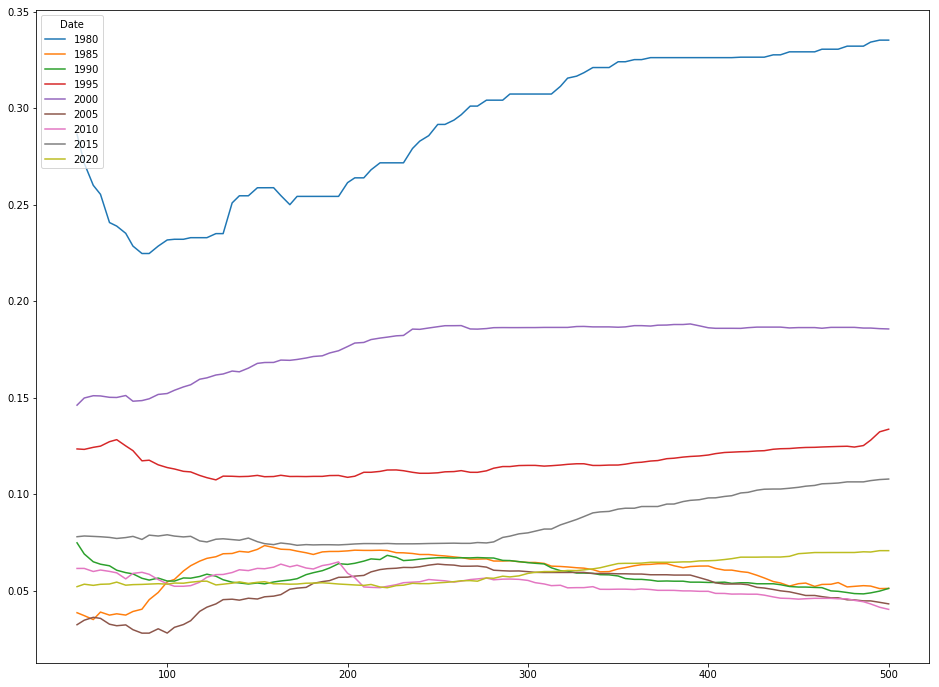

In [42]:
(
    moving_averages["1980":]
    .add(1).apply(np.log)
    .groupby(pd.Grouper(freq='5Y'))
    .mean().mul(250).apply(np.exp).sub(1)
    .rename(index=lambda x: x.year).dropna().T.plot()
)

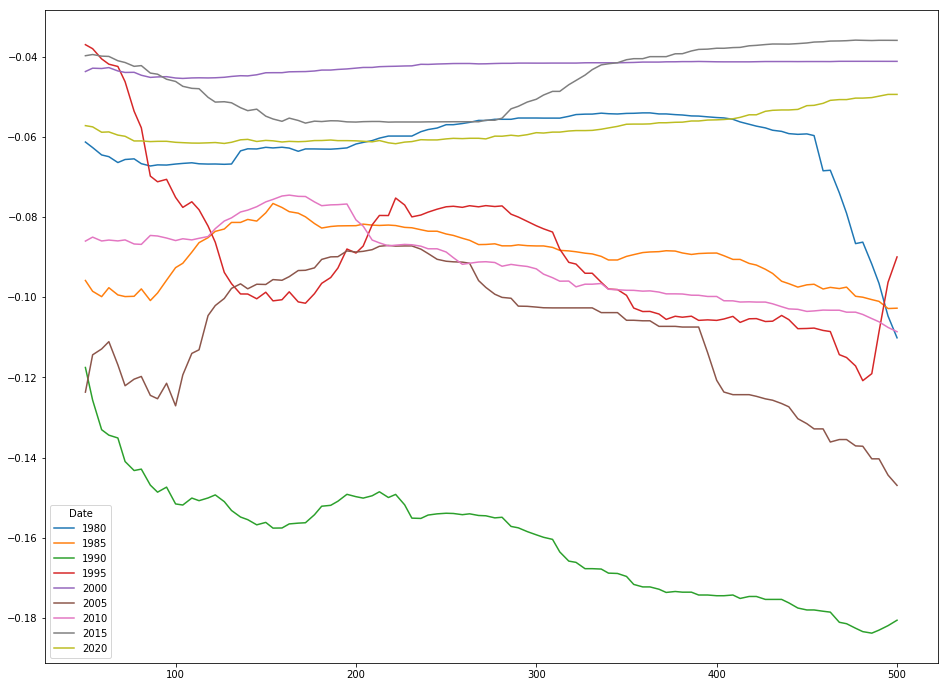

In [40]:
moving_averages_nav = moving_averages.add(1).cumprod()
moving_averages_dd = moving_averages_nav / moving_averages_nav.cummax() - 1
(
    moving_averages_dd["1980":]
    .groupby(pd.Grouper(freq='5Y')).mean()
    .rename(index=lambda x: x.year).dropna().T.plot()
)

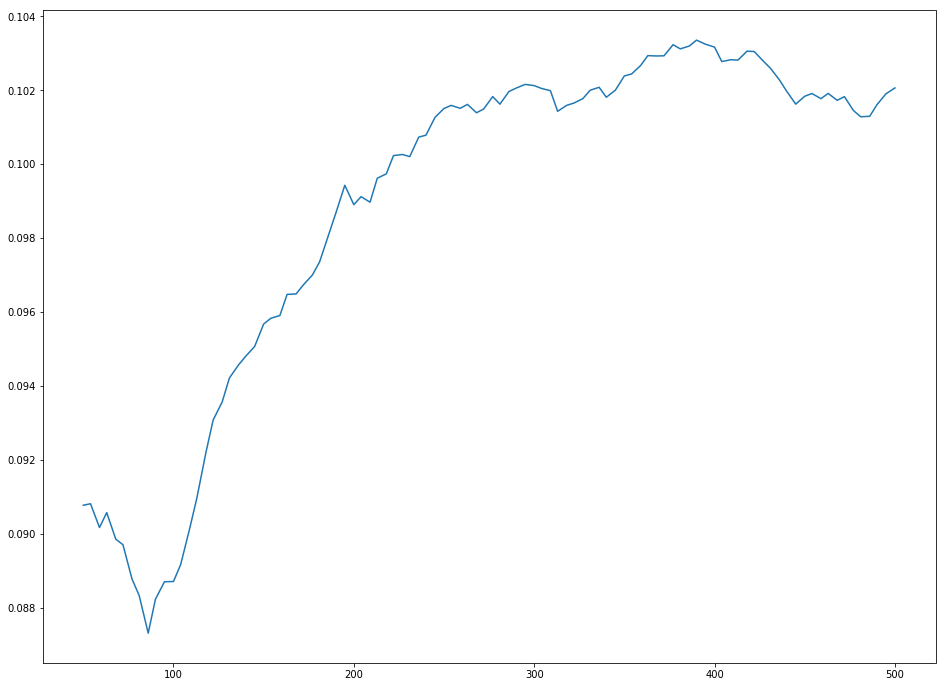

In [56]:
# Average return per year is good for MA200 and above after 1980
(
    moving_averages["1980":]
    .add(1).apply(np.log)
    .rolling(250).mean().mul(250)
    .apply(np.exp).sub(1).mean()
    .plot()
)

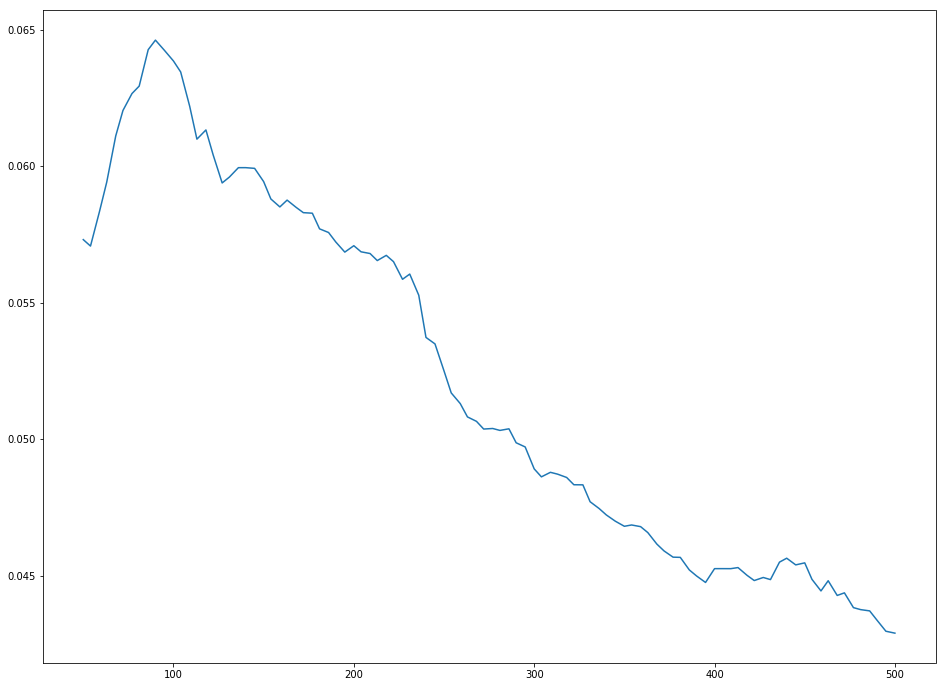

In [57]:
# Not so good before that 
(
    moving_averages[:"1979"]
    .add(1).apply(np.log)
    .rolling(250).mean().mul(250)
    .apply(np.exp).sub(1).mean()
    .plot()
)

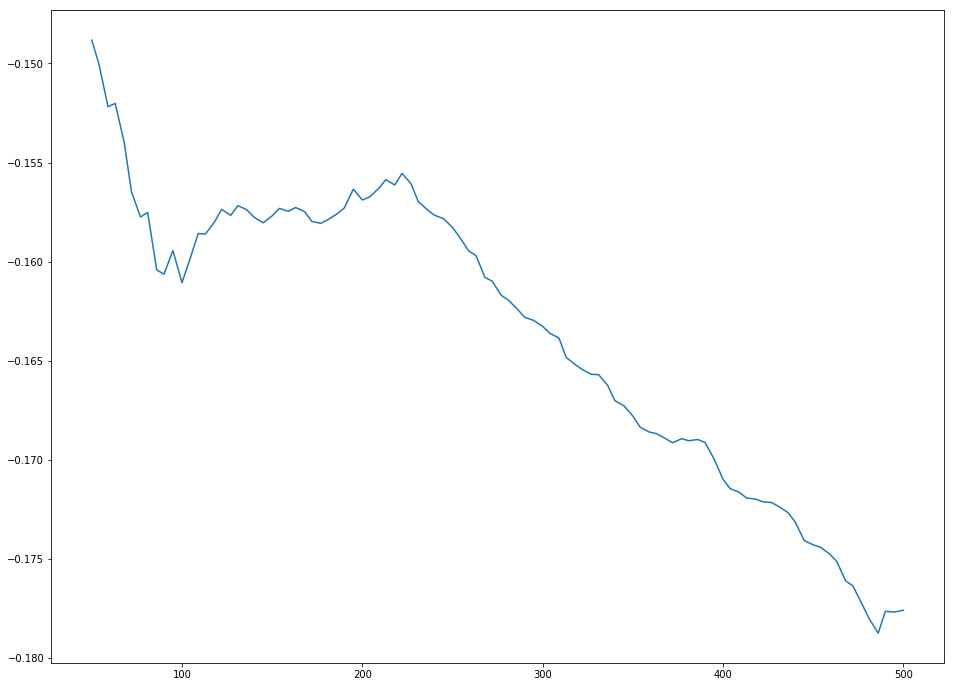

In [47]:
# Similarly, drawdowns are good for MA200 and below after 1980
moving_averages_dd["1980":].rolling(250).min().mean().plot()

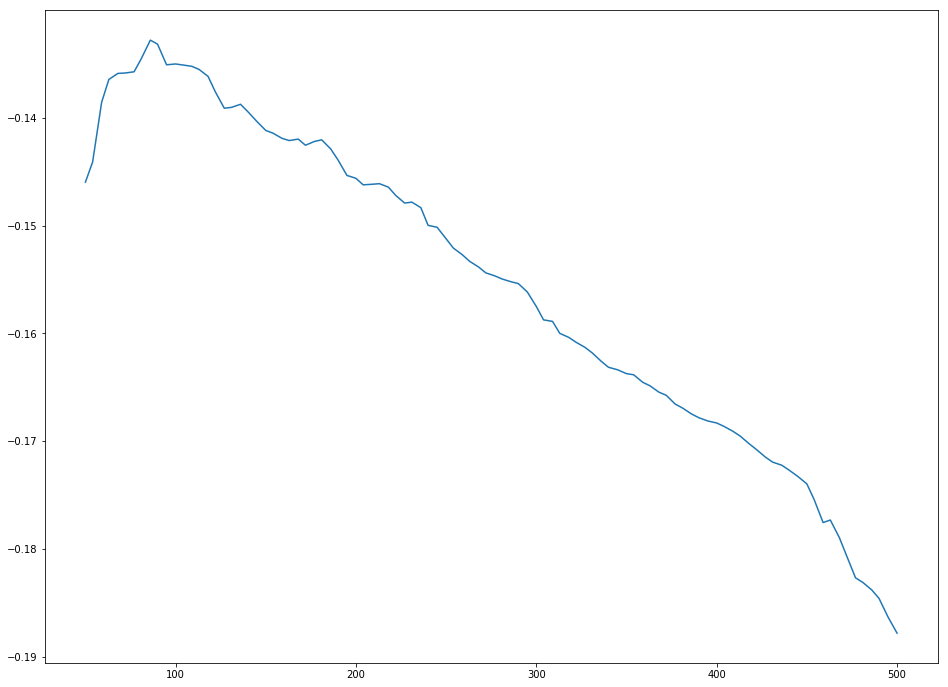

In [49]:
# Again, not so much of an effect before that
moving_averages_dd[:"1979"].rolling(250).min().mean().plot()